## Image segmentation with CamVid

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
torch.cuda.set_device(3)

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [ ]:
path = Path('./data/camvid-tiramisu')

In [ ]:
path.ls()

[PosixPath('data/camvid-tiramisu/valannot'),
 PosixPath('data/camvid-tiramisu/test'),
 PosixPath('data/camvid-tiramisu/val'),
 PosixPath('data/camvid-tiramisu/val.txt'),
 PosixPath('data/camvid-tiramisu/trainannot'),
 PosixPath('data/camvid-tiramisu/testannot'),
 PosixPath('data/camvid-tiramisu/train'),
 PosixPath('data/camvid-tiramisu/test.txt'),
 PosixPath('data/camvid-tiramisu/train.txt'),
 PosixPath('data/camvid-tiramisu/models')]

## Data

In [ ]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('data/camvid-tiramisu/val/0016E5_08065.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_07989.png'),
 PosixPath('data/camvid-tiramisu/val/0016E5_08041.png')]

In [ ]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('data/camvid-tiramisu/valannot/0016E5_08065.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_07989.png'),
 PosixPath('data/camvid-tiramisu/valannot/0016E5_08041.png')]

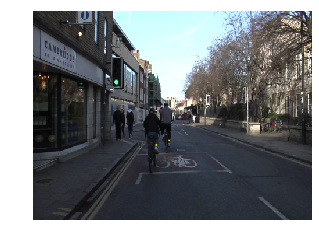

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

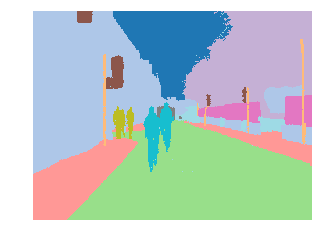

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3]]]))

## Datasets

In [ ]:
bs,size = 8,src_size//2

In [ ]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

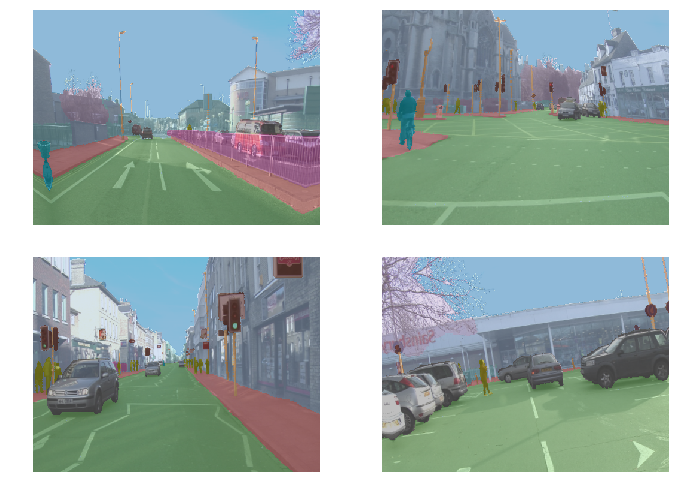

In [ ]:
data.show_batch(2, figsize=(10,7))

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


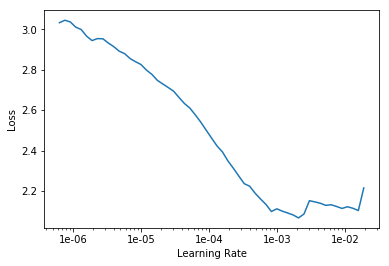

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=2e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.797555,1.140855,0.666712
2,1.108703,0.773872,0.779746
3,0.780712,0.517655,0.865303
4,0.618028,0.496499,0.866009
5,0.542120,0.484854,0.861792
6,0.490998,0.412183,0.857062
7,0.458476,0.363839,0.895877
8,0.426327,0.377631,0.885415
9,0.381760,0.307907,0.908467
10,0.325531,0.288052,0.907133


In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/100,lr)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.277594,0.273819,0.913931
2,0.271254,0.266760,0.916620
3,0.269084,0.269211,0.915474
4,0.273889,0.295377,0.914132
5,0.268701,0.312179,0.906329
6,0.295838,0.363080,0.902990
7,0.304576,0.323809,0.898795
8,0.290066,0.267403,0.920294
9,0.274901,0.274512,0.914693
10,0.275207,0.273877,0.920632


In [ ]:
learn.save('stage-2');

## Go big

In [ ]:
learn=None
gc.collect()

4194

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
size = src_size
bs=8

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


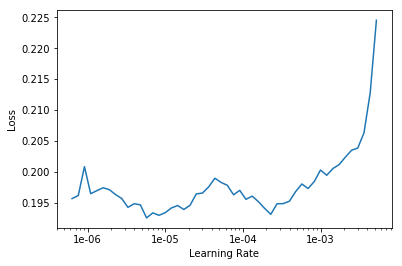

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.197342,0.242197,0.929653
2,0.195649,0.237269,0.930523
3,0.192771,0.253759,0.926123
4,0.197877,0.244278,0.931226
5,0.197267,0.255444,0.927470
6,0.206536,0.371523,0.913392
7,0.210372,0.267855,0.927450
8,0.210874,0.278875,0.915120
9,0.205951,0.256743,0.929986
10,0.184149,0.227250,0.939358


In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/1000,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.163259,0.226014,0.939663
2,0.159221,0.223871,0.940497
3,0.159171,0.242006,0.938531
4,0.158257,0.223698,0.941702
5,0.156215,0.227719,0.941239
6,0.155152,0.226728,0.941032
7,0.150818,0.230083,0.940657
8,0.149479,0.229187,0.940948
9,0.148236,0.229072,0.941316
10,0.148074,0.234124,0.940629


In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

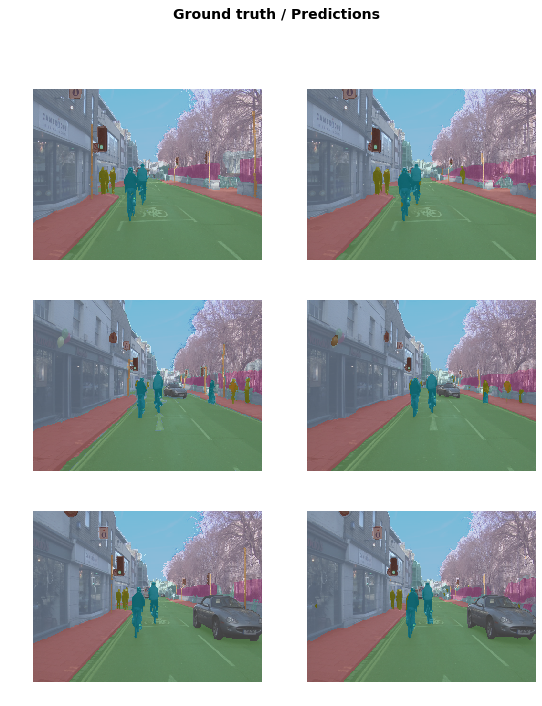

In [ ]:
learn.show_results(rows=3, figsize=(9,11))

## fin